In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from math import ceil
import os

# Plotting Function

In [7]:
def load_data(path_to_runs):
    runs = os.listdir(path_to_runs)
    dfs = {}
    for run in runs:
        if run.endswith('.csv'):  
            run_number = run.split('.')[0]
            file_path = os.path.join(path_to_runs, run)  
            try:
                df = pd.read_csv(file_path)
                df.drop_duplicates(inplace=True)  
                dfs[run_number] = df
            except Exception as e:
                print(f"Failed to load {run}: {e}")  
    return dfs


def create_graphs(dfs):
    graphs = {}
    layer_mapping = {key: i for i, key in enumerate(dfs.keys())}
    combined_graph = nx.DiGraph()

    # Collect all channels that ever appear as Training=True
    training_channels = set()
    for df in dfs.values():
        training_channels.update(df[df['Training'] == True]['Channel'].unique())

    for key, df in dfs.items():
        G = nx.DiGraph()
        for i in range(len(df) - 1):
            src, tgt = df.iloc[i]['Channel'], df.iloc[i + 1]['Channel']
            # Treat channel as training if it ever appears as training
            src_train = src in training_channels
            tgt_train = tgt in training_channels
            G.add_node(src, Training=src_train, layer=layer_mapping[key])
            G.add_node(tgt, Training=tgt_train, layer=layer_mapping[key])
            if src != tgt:
                G.add_edge(src, tgt)
        graphs[key] = G
        combined_graph = nx.compose(combined_graph, G)

    return combined_graph, layer_mapping, graphs



def adjust_graph_layers(combined_graph, layer_mapping):
    total_layers = list(layer_mapping.values())
    median_layer = ceil(np.median(total_layers))
    for node, data in combined_graph.nodes(data=True):
        if data['Training']:
            data['layer'] = median_layer
            
    pos = graphviz_layout(combined_graph, prog='dot')

    # Spread nodes in the same adjusted layer horizontally to emphasize parallel paths
    layers = {}

    for node, data in combined_graph.nodes(data=True):
        layer = data['layer']
        if layer not in layers:
            layers[layer] = []
        layers[layer].append(node)

    for layer, nodes in layers.items():
        for i, node in enumerate(nodes):
            pos[node] = (layer * 150, pos[node][1] )  
        
    minimum_distance = 150  # Can be adjusted
    layers = {layer: [] for layer in layer_mapping.values()}

    # Assign nodes to layers
    for node, data in combined_graph.nodes(data=True):
        layers[data['layer']].append(node)

    # First, sort and adjust within layers
    for layer, nodes in layers.items():
        if not nodes:
            continue
        sorted_nodes = sorted(nodes, key=lambda n: pos[n][1])
        for i in range(1, len(sorted_nodes)):
            current_pos = pos[sorted_nodes[i]][1]
            previous_pos = pos[sorted_nodes[i - 1]][1]
            if current_pos - previous_pos < minimum_distance:
                pos[sorted_nodes[i]] = (pos[sorted_nodes[i]][0], previous_pos + minimum_distance)
        

    # First pass to find the lowest y-position of training nodes across all layers
    min_y_for_training = float('inf')
    for node, data in combined_graph.nodes(data=True):
        if data['Training'] and pos[node][1] < min_y_for_training:
            min_y_for_training = pos[node][1]

    #Second pass to adjust y-positions for non-training nodes
    adjustment = {}
    for node, data in combined_graph.nodes(data=True):
        if not data['Training']:
            layer = data['layer']
            if layer not in adjustment:
                # Find the highest y-position of non-training nodes in the same layer
                max_y_in_layer = max(pos[n][1] for n in combined_graph.nodes if combined_graph.nodes[n]['layer'] == layer and not combined_graph.nodes[n]['Training'] and np.isfinite(pos[n][1]))
                adjustment[layer] = min_y_for_training - max_y_in_layer - 300
            # Apply adjustment, ensuring all positions are finite
            if np.isfinite(pos[node][1]):
                pos[node] = (pos[node][0], pos[node][1] + adjustment.get(layer, 0))

    # Ensure all positions are finite and adjust if necessary
    for node in pos:
        if not np.isfinite(pos[node][1]):
            # Fallback position if non-finite values found
            pos[node] = (pos[node][0], 0)  

    return pos


def visualize_network_graph(path_to_runs, plot_name):
    dfs = load_data(path_to_runs)
    combined_graph, layer_mapping, graphs= create_graphs(dfs)
    pos = adjust_graph_layers(combined_graph, layer_mapping)
    
     # Determine indegrees and assign shapes
    indegrees = combined_graph.in_degree()
    shapes = [' ', 'o', '^', 'd', 'p','*'] 
    shape_legend = {}
    for node, deg in indegrees:
        if deg > 0:
            shape = shapes[deg % len(shapes)] if deg < len(shapes) else shapes[-1]
            shape_legend[deg] = shape
        else:
            shape = 'o'
        combined_graph.nodes[node]['shape'] = shape


    plt.figure(figsize=(18, 15))
    colors = [
    'skyblue', 'lightgreen', 'purple', 'red', 'grey', 'pink', 'brown',
    'cyan', 'magenta', 'lime', 'olive', 'chocolate', 'coral', 'lightblue',
    'darkgreen', 'lavender', 'maroon', 'navy', 'goldenrod', 'teal'
    ]

    edge_colors = [
    'blue', 'green', 'purple', 'red', 'darkgrey', 'pink', 'brown',
    'cyan', 'magenta', 'lime', 'olive', 'chocolate', 'coral', 'lightblue',
    'darkgreen', 'lavender', 'maroon', 'navy', 'goldenrod', 'teal'
    ]

    # Draw all nodes first
    for node in combined_graph.nodes():
        node_data = combined_graph.nodes[node]
        color = 'orange' if node_data['Training'] else colors[node_data['layer'] % len(colors)]
        shape = node_data['shape']
        nx.draw_networkx_nodes(combined_graph, pos, nodelist=[node], node_color=color, node_shape=shape, node_size=300, alpha=0.6)

    # Draw the graphs, separating calls by node shape
    for i, (key, graph) in enumerate(graphs.items()):
        nx.draw_networkx_edges(graph, pos, edge_color=edge_colors[i], style='solid', arrows=True)


    # Draw edges
    nx.draw_networkx_labels(combined_graph, pos, font_color='black', font_size=9)

    # Create a sorted list of legend entries based on indegree
    sorted_legend_entries = sorted(shape_legend.items(), key=lambda item: item[0])
    for deg, shape in sorted_legend_entries:
        plt.scatter([], [], c='gray', alpha=0.6, s=100, marker=shape, label=f'Indegree {deg}')

    plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Node Shapes')

    plt.title(plot_name)
    plt.axis('off')
    plt.show()



def extract_last_titles_and_channels(path_to_runs):
    dfs = load_data(path_to_runs)  # Assume this function loads DataFrames properly
    last_row_info = {}
    sorted_keys = sorted(dfs.keys())  # Sort the keys to maintain a consistent order

    for index, run_number in enumerate(sorted_keys, start=1):
        df = dfs[run_number]
        if not df.empty:
            last_title = df.iloc[-1]['Title']
            last_channel = df.iloc[-1]['Channel']
        else:
            last_title = 'None'
            last_channel = 'None'
        
        # Print directly instead of returning
        print(f"Path{index}:")
        print(f"  Title: {last_title}")
        print(f"  Channel: {last_channel}")
        print() 



## SVP

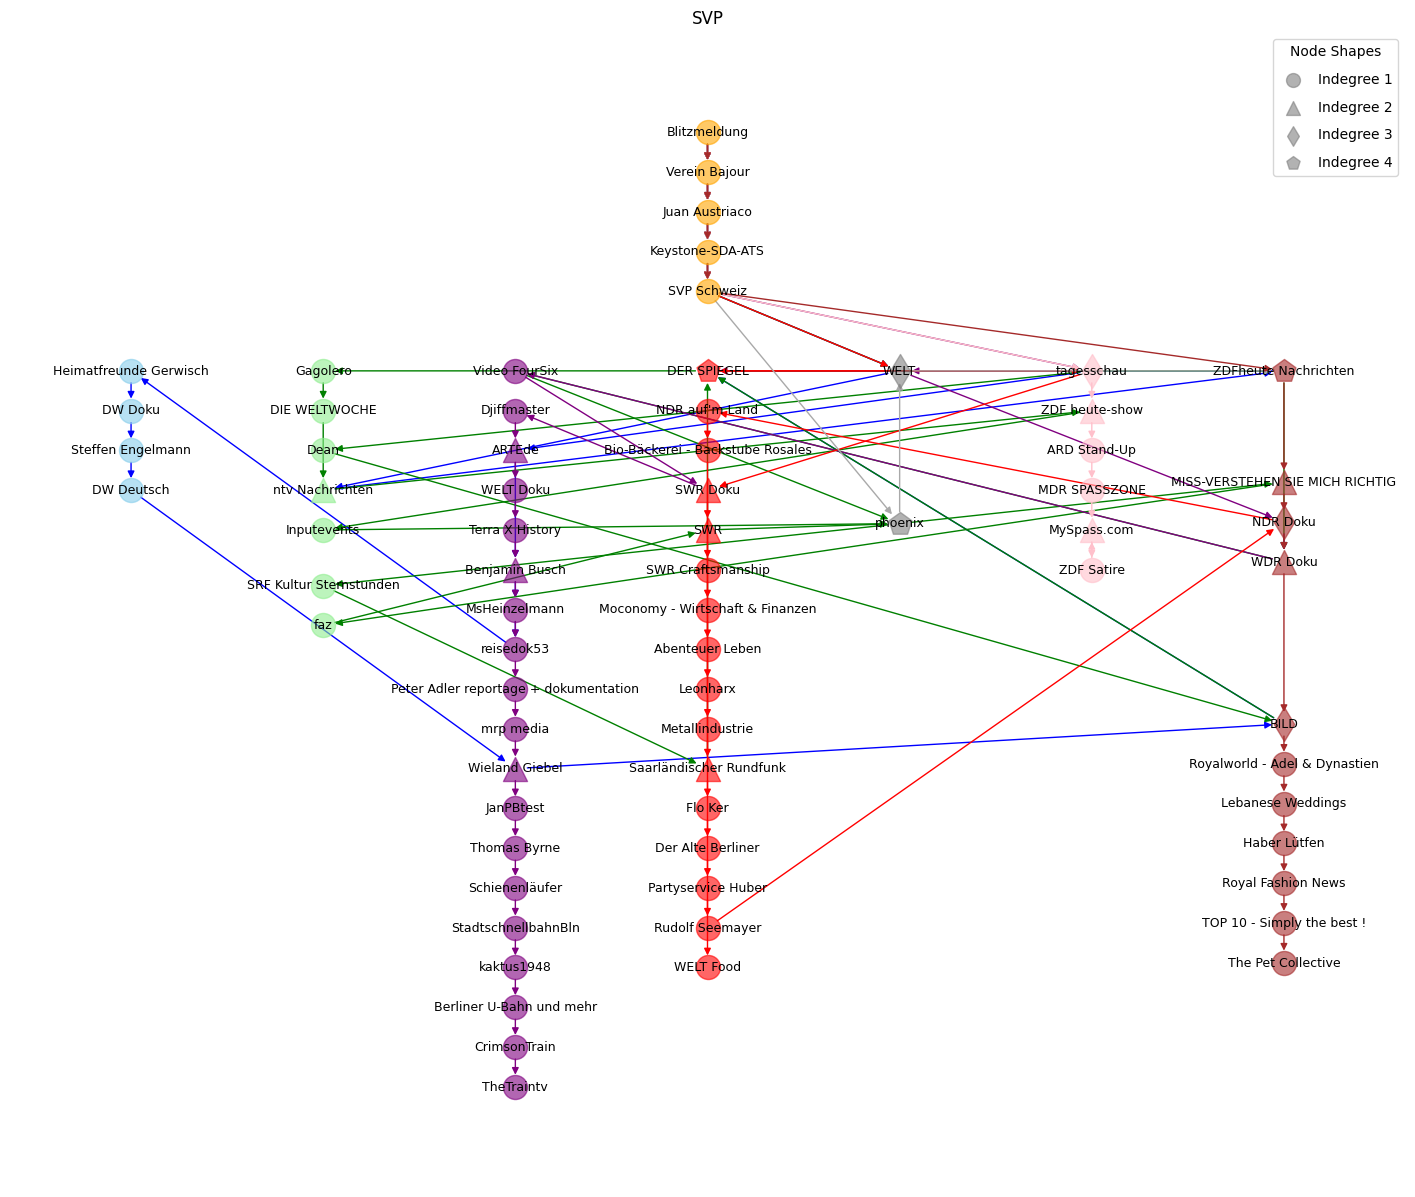

Path1:
  Title: Königreich Deutschland: Reichsbürger auf Expansionskurs | SPIEGEL TV
  Channel: DER SPIEGEL

Path2:
  Title: WURSTPARADIES DEUTSCHLAND: Diese Betriebe halten das Traditionshandwerk am Leben | Die Foodtruckerin
  Channel: WELT Food

Path3:
  Title: "Aufstand im Osten. Spaltet die Wahl das Land?" - Peter Hahne vom 30.09.2017
  Channel: phoenix

Path4:
  Title: Olaf Schubert - wenn der Heli nur noch schraubt - 1LIVE Köln Comedy-Nacht XXL
  Channel: MySpass.com

Path5:
  Title: Podcast: Verlieren wir unsere Kinder durchs Smartphone? | Lanz & Precht
  Channel: ZDFheute Nachrichten

Path6:
  Title: Berliner S-Bahn Retro: 1990 im Führerstand über die Berliner Stadtbahn
  Channel: TheTraintv

Path7:
  Title: The FUNNIEST Animal Shorts Ever!
  Channel: The Pet Collective



In [9]:
path = '../select_runs/SVP/'
name='SVP'
visualize_network_graph(path, name)
extract_last_titles_and_channels(path)

## Pizza

/home/tiago/ans-project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tiago/ans-project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53441 (\N{HANGUL SYLLABLE TAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tiago/ans-project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tiago/ans-project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tiago/ans-project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50556 (\N{HANGUL SYL

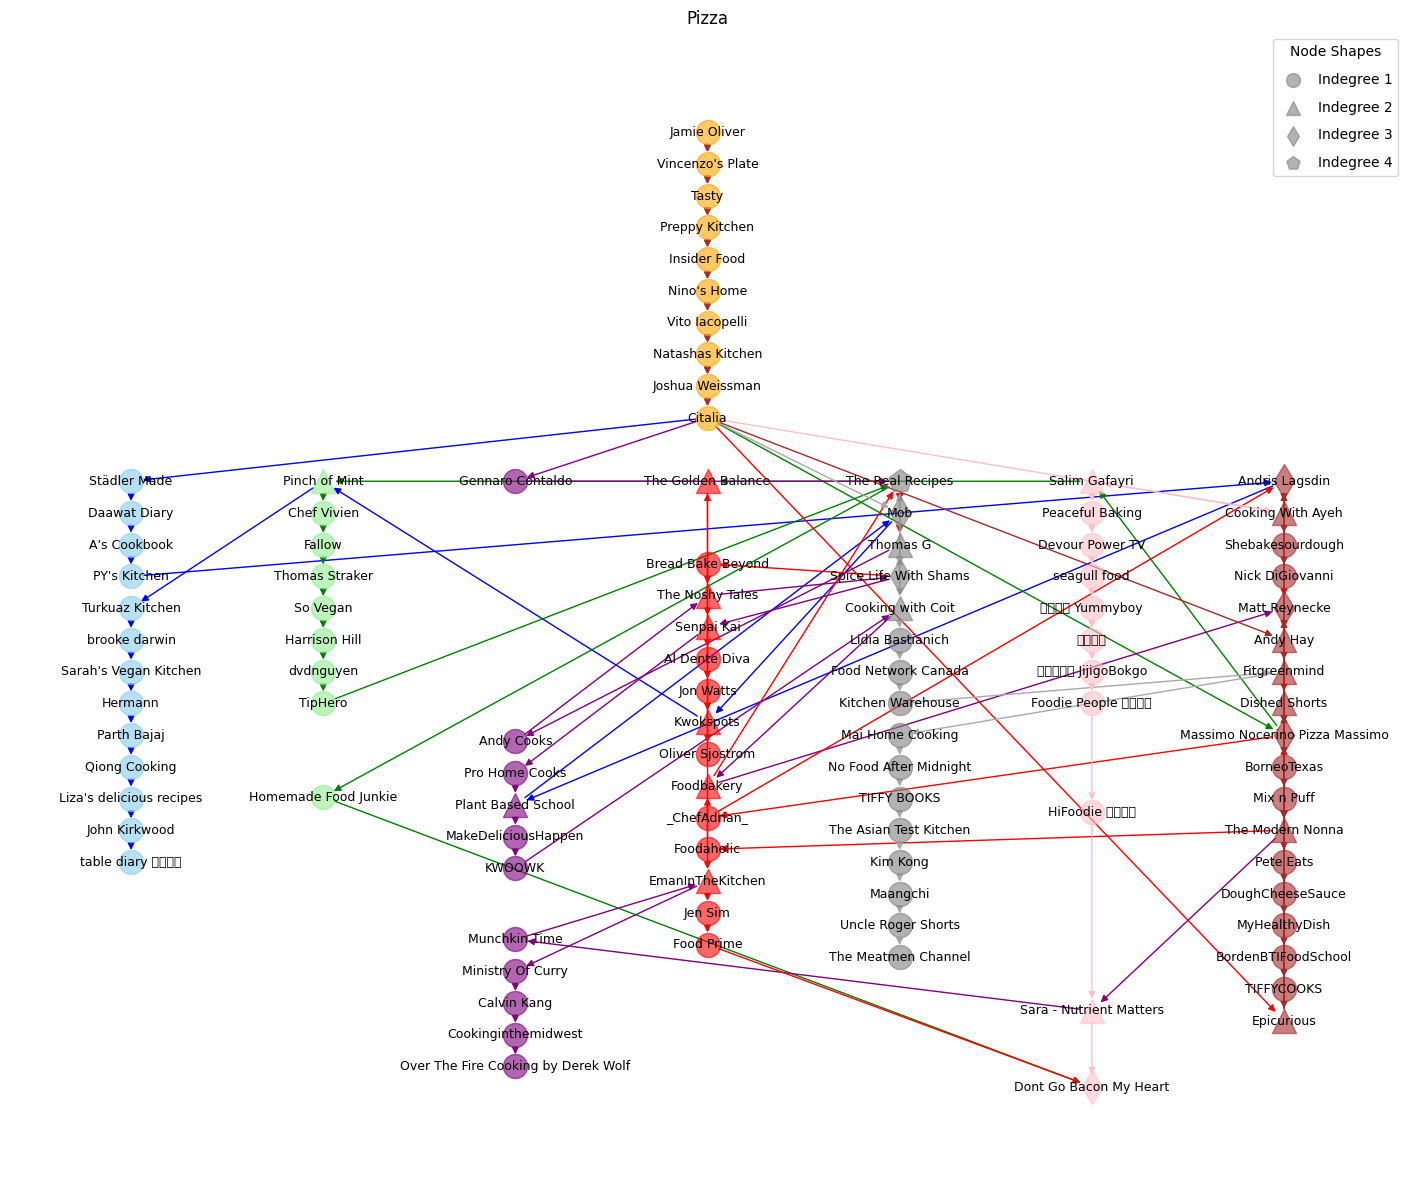

Path1:
  Title: Creamy Lemon Salmon
  Channel: Dont Go Bacon My Heart

Path2:
  Title: No Knead Cheese Bread (It is amazing EASY and DELICIOUS)
  Channel: table diary 식탁일기

Path3:
  Title: Tomahawk Steak with Garlic Butter Lobster Recipe | Over The Fire Cooking by Derek Wolf
  Channel: Over The Fire Cooking by Derek Wolf

Path4:
  Title: Asparagus Pancetta Pasta
  Channel: Dont Go Bacon My Heart

Path5:
  Title: Day 3 of 20 minute dinners - Scallion Chicken (must try!)
  Channel: TIFFYCOOKS

Path6:
  Title: Lao Gan Ma Fried Rice Recipe - The Perfect One-Pan Meal #shorts
  Channel: The Meatmen Channel

Path7:
  Title: Garlic Butter Salmon
  Channel: Dont Go Bacon My Heart



In [10]:
path = '../select_runs/pizza-runs/'
name='Pizza'
visualize_network_graph(path,  name)
extract_last_titles_and_channels(path)

## AFD

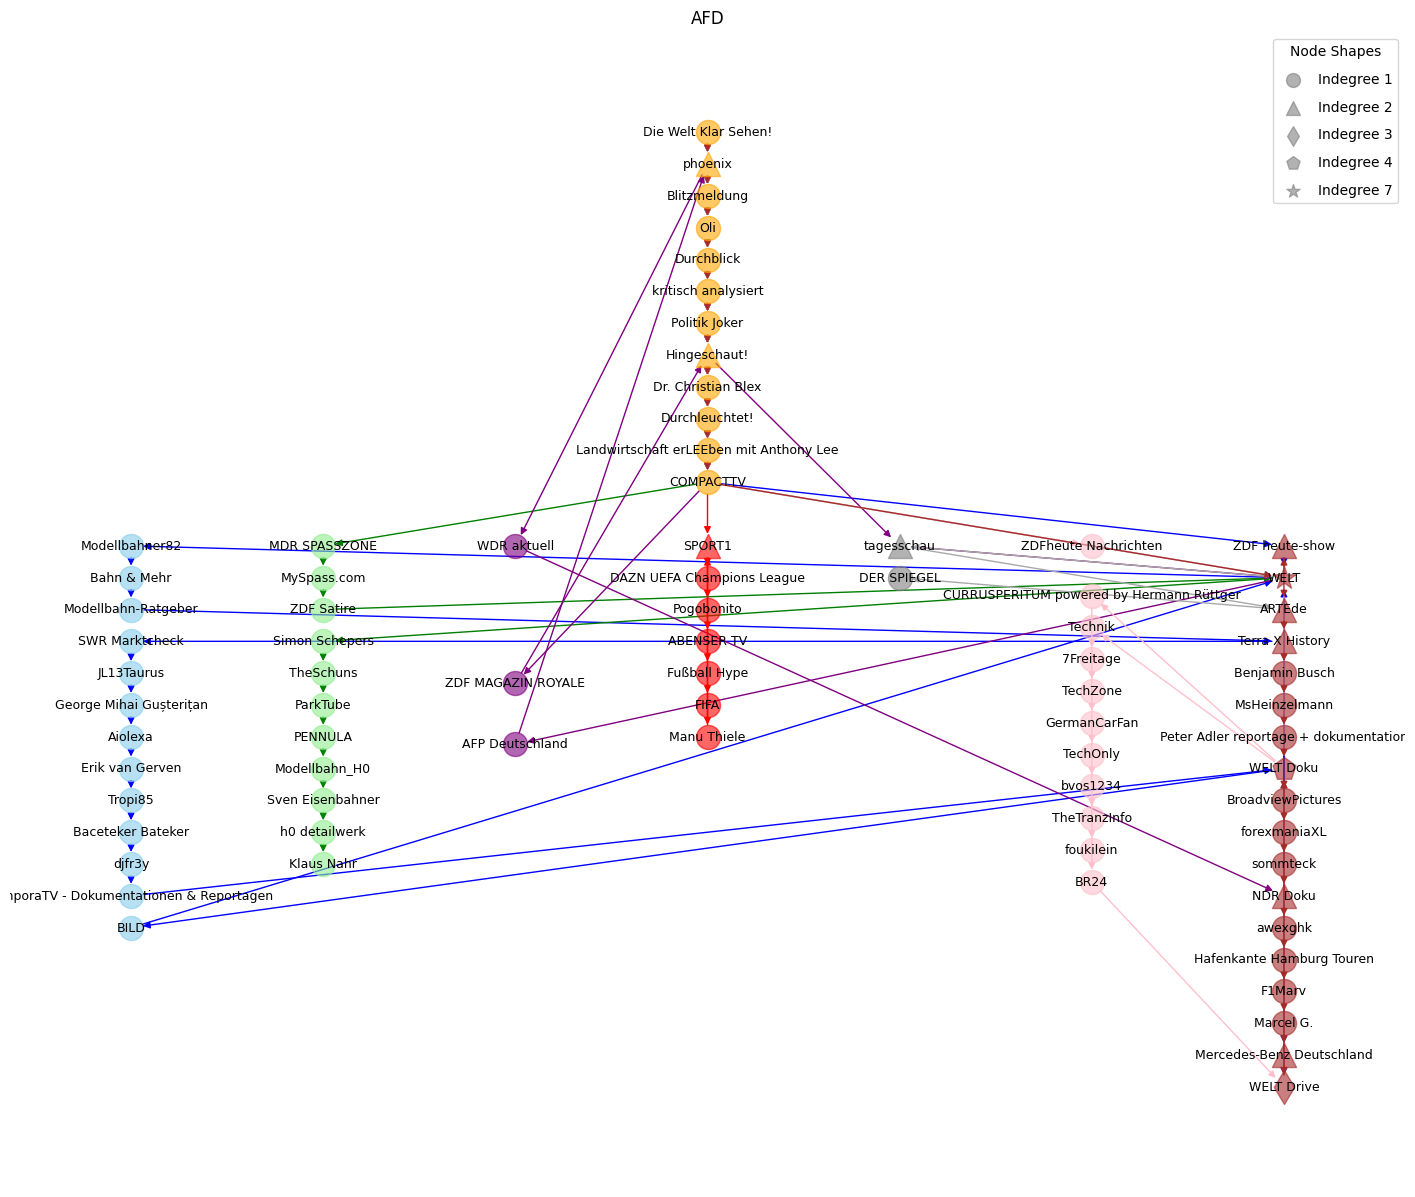

Path1:
  Title: Die Akte Stromlinie
  Channel: Mercedes-Benz Deutschland

Path2:
  Title: Fazination Modellbahn 2023 Mannheim
  Channel: Klaus Nahr

Path3:
  Title: Russlanddeutsche, die AfD und ich | Doku | NDR Story
  Channel: NDR Doku

Path4:
  Title: France v Brazil | 2019 FIFA Women's World Cup | Full Match
  Channel: FIFA

Path5:
  Title: Die Davidwache: Blaulichtalarm im Rotlichtviertel | SPIEGEL TV
  Channel: DER SPIEGEL

Path6:
  Title: Mitsubishi Sigma 24V vs. Mercedes 300E 24V
  Channel: foukilein

Path7:
  Title: RUF CTR YELLOWBIRD: Porsche ist für dieses Supercar-Manufaktur kein Konkurrent | WELT Doku
  Channel: WELT Doku



In [36]:
path = '../select_runs/AFD/'
name='AFD'
visualize_network_graph(path,name)
extract_last_titles_and_channels(path)

## Italy travel guide

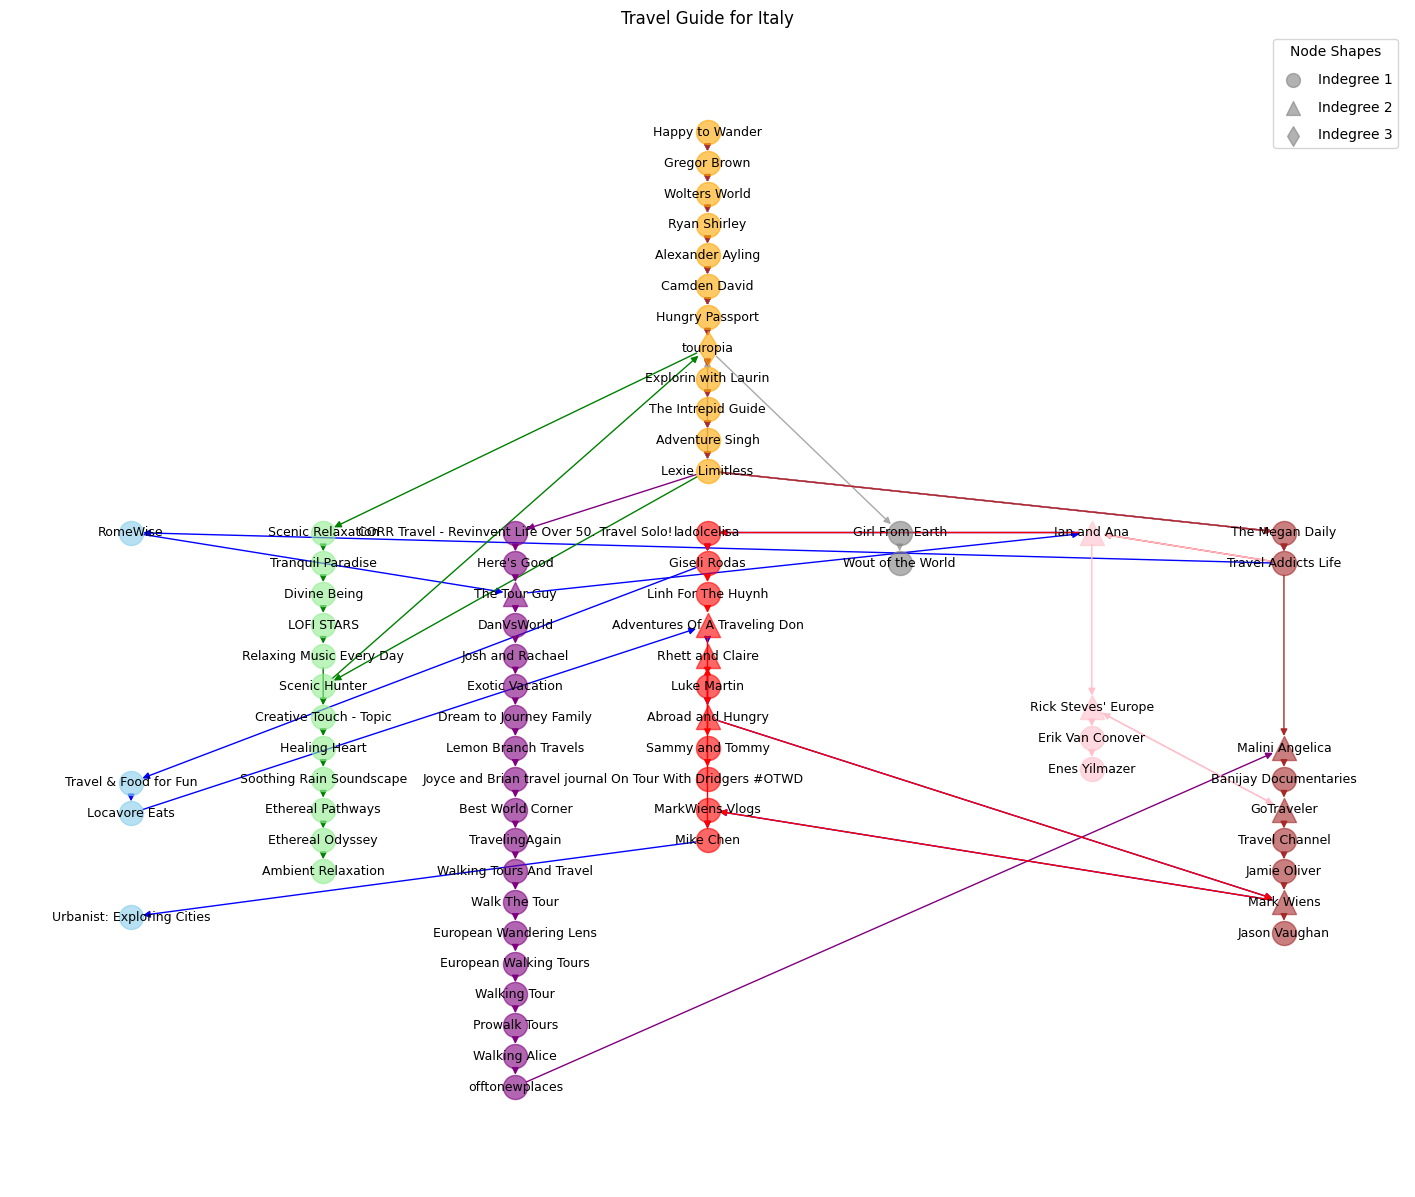

Path1:
  Title: Is there more to Greek Music than Zorba?
  Channel: Urbanist: Exploring Cities

Path2:
  Title: CASTLE - Relaxing Ambient Music with Night Sound for Stress Relief, Meditation, Study, Focus & Sleep
  Channel: Ambient Relaxation

Path3:
  Title: WHEN IN ROME, DO AS THE ROMANS DO!! (Italy)
  Channel: Malini Angelica

Path4:
  Title: CASABLANCA | Our SHOCKING First Day In Modern Morocco 🇲🇦 د فعل بريطان
  Channel: On Tour With Dridgers #OTWD

Path5:
  Title: PHILIPPINES Best Nature!? This island HAS IT ALL: Beaches, CHOCOLATE Hills & Tarsiers
  Channel: Wout of the World

Path6:
  Title: Touring the Most Expensive House for Sale in Dubai!
  Channel: Enes Yilmazer

Path7:
  Title: Lisbon Portuguese Street Food Tour 2022 - GIANT SEAFOOD FEASTS, CUSTARD TARTS & PREGO MEAT DESSERT
  Channel: Jason Vaughan



In [59]:
path = '../Travel_italy/'
name='Travel Guide for Italy'
visualize_network_graph(path,name)
extract_last_titles_and_channels(path)

## Gun-Type

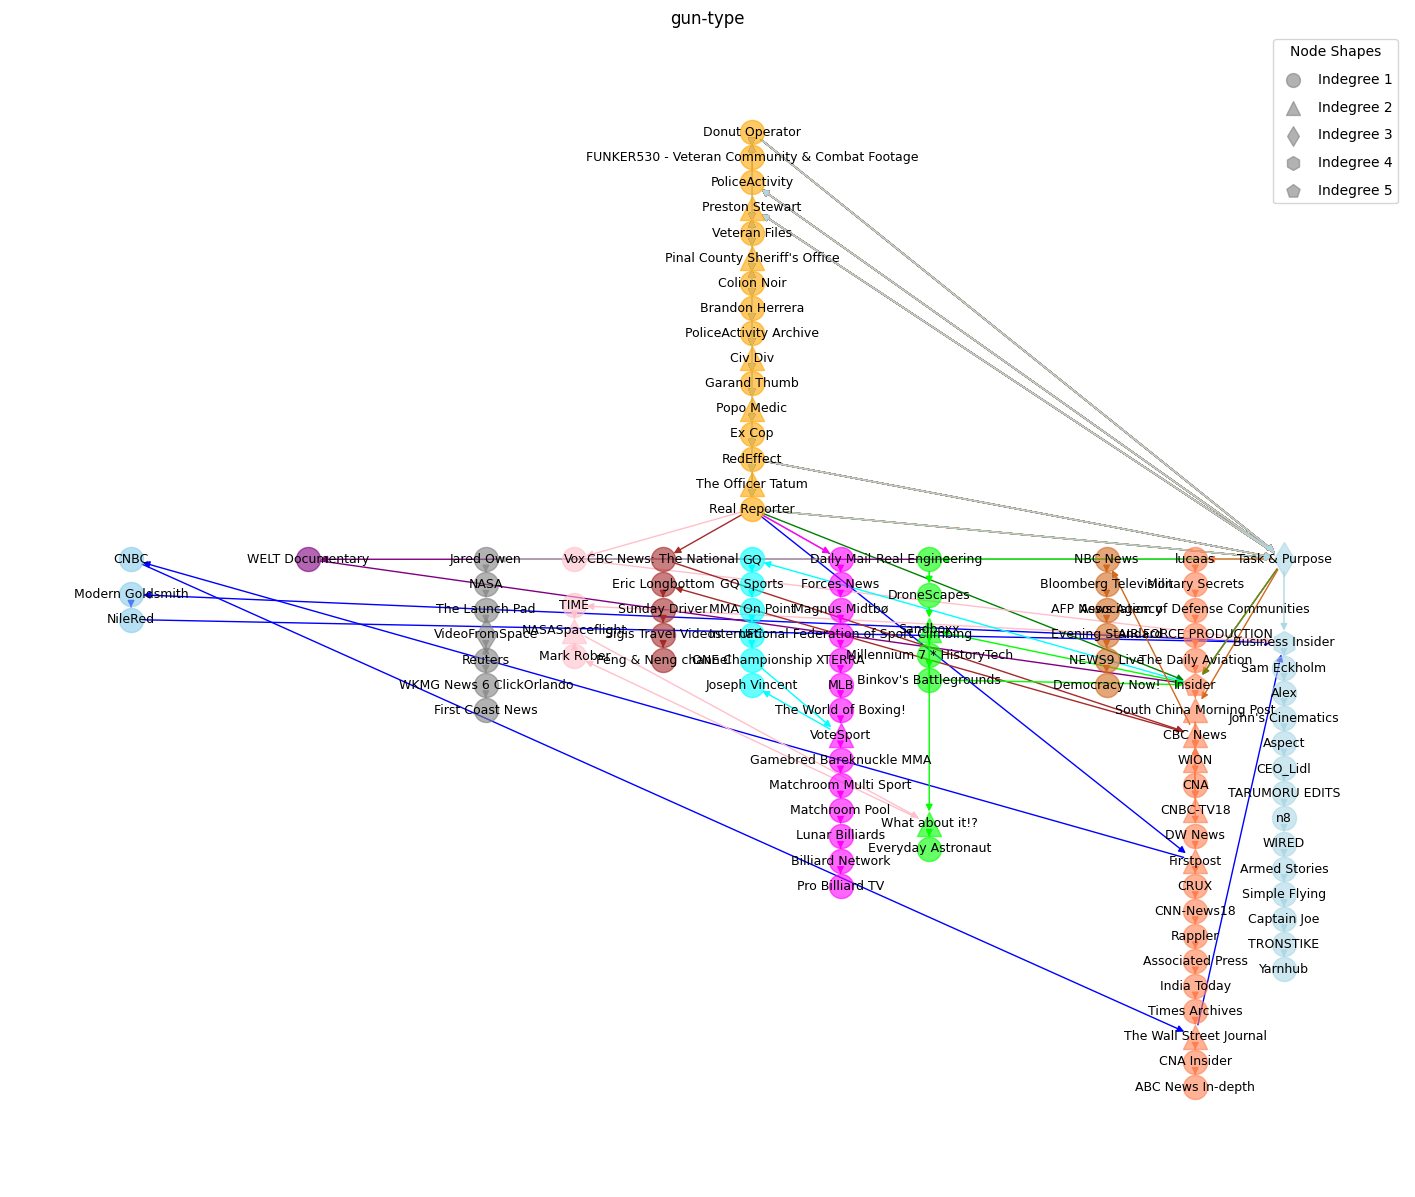

In [54]:
visualize_network_graph('../select_runs/gun-type', "gun-type")

## Left

/home/tiago/ans-project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12497 (\N{KATAKANA LETTER PA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tiago/ans-project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tiago/ans-project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12418 (\N{HIRAGANA LETTER MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tiago/ans-project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tiago/ans-project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12364 (\N{HIRAGANA LETT

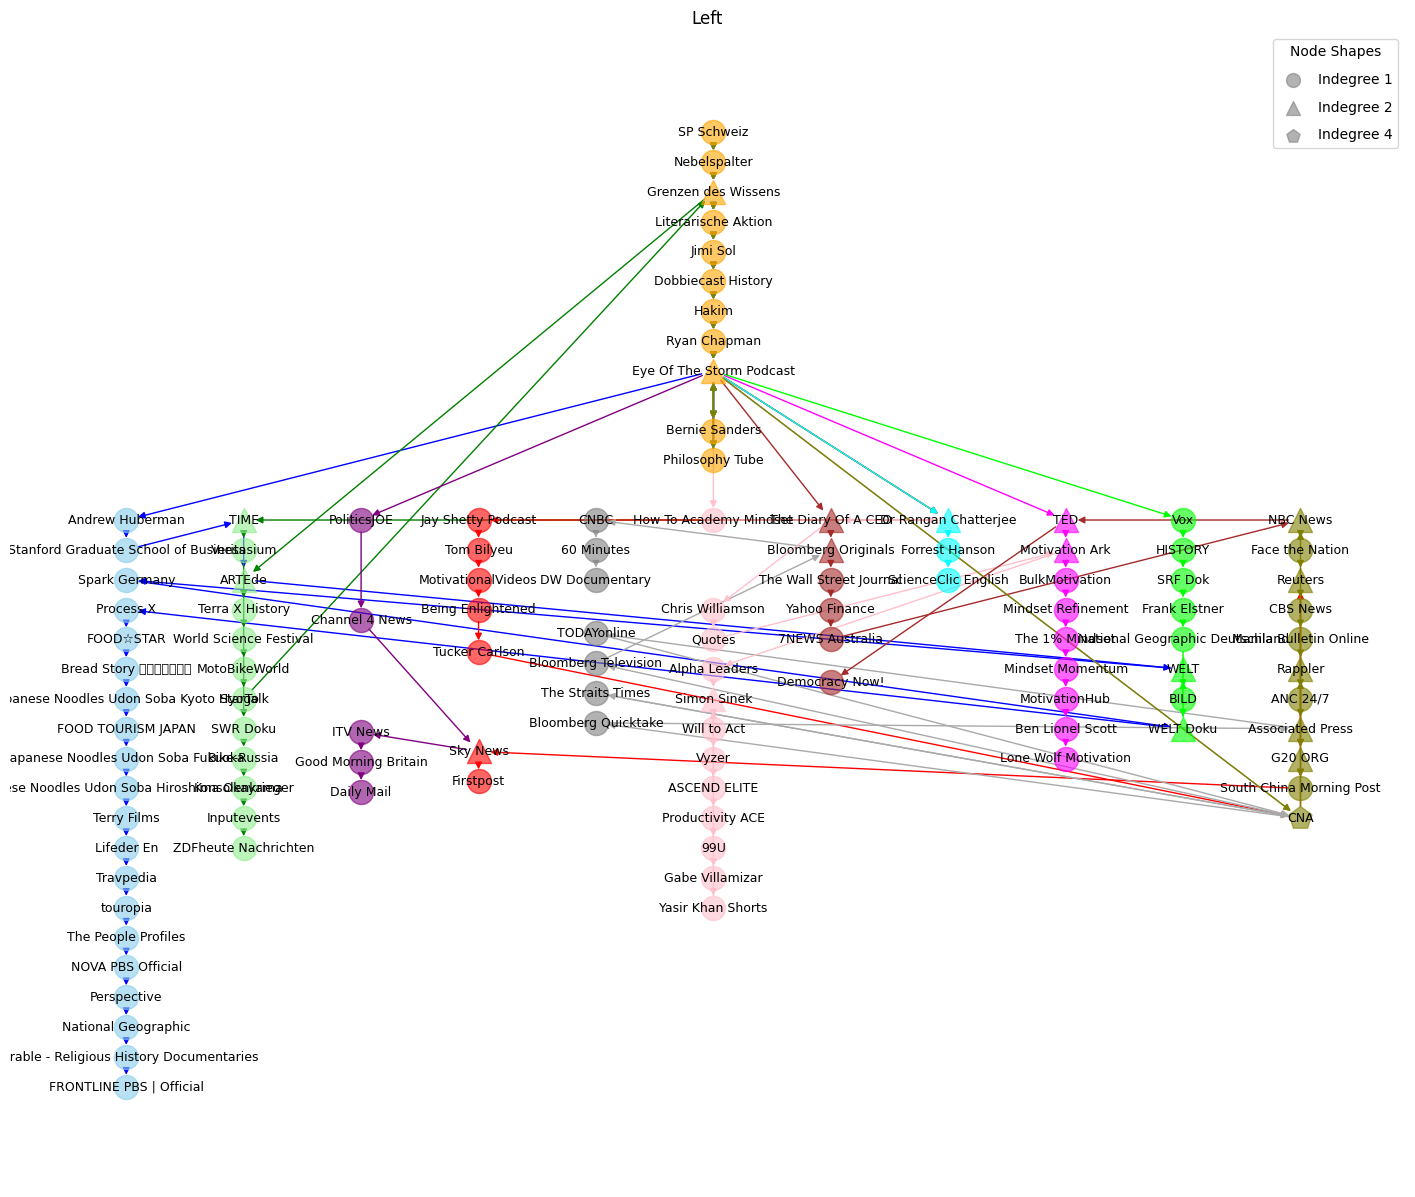

In [11]:

path = '../select_runs/Left/'
name='Left'
visualize_network_graph(path, name)

## Minecraft

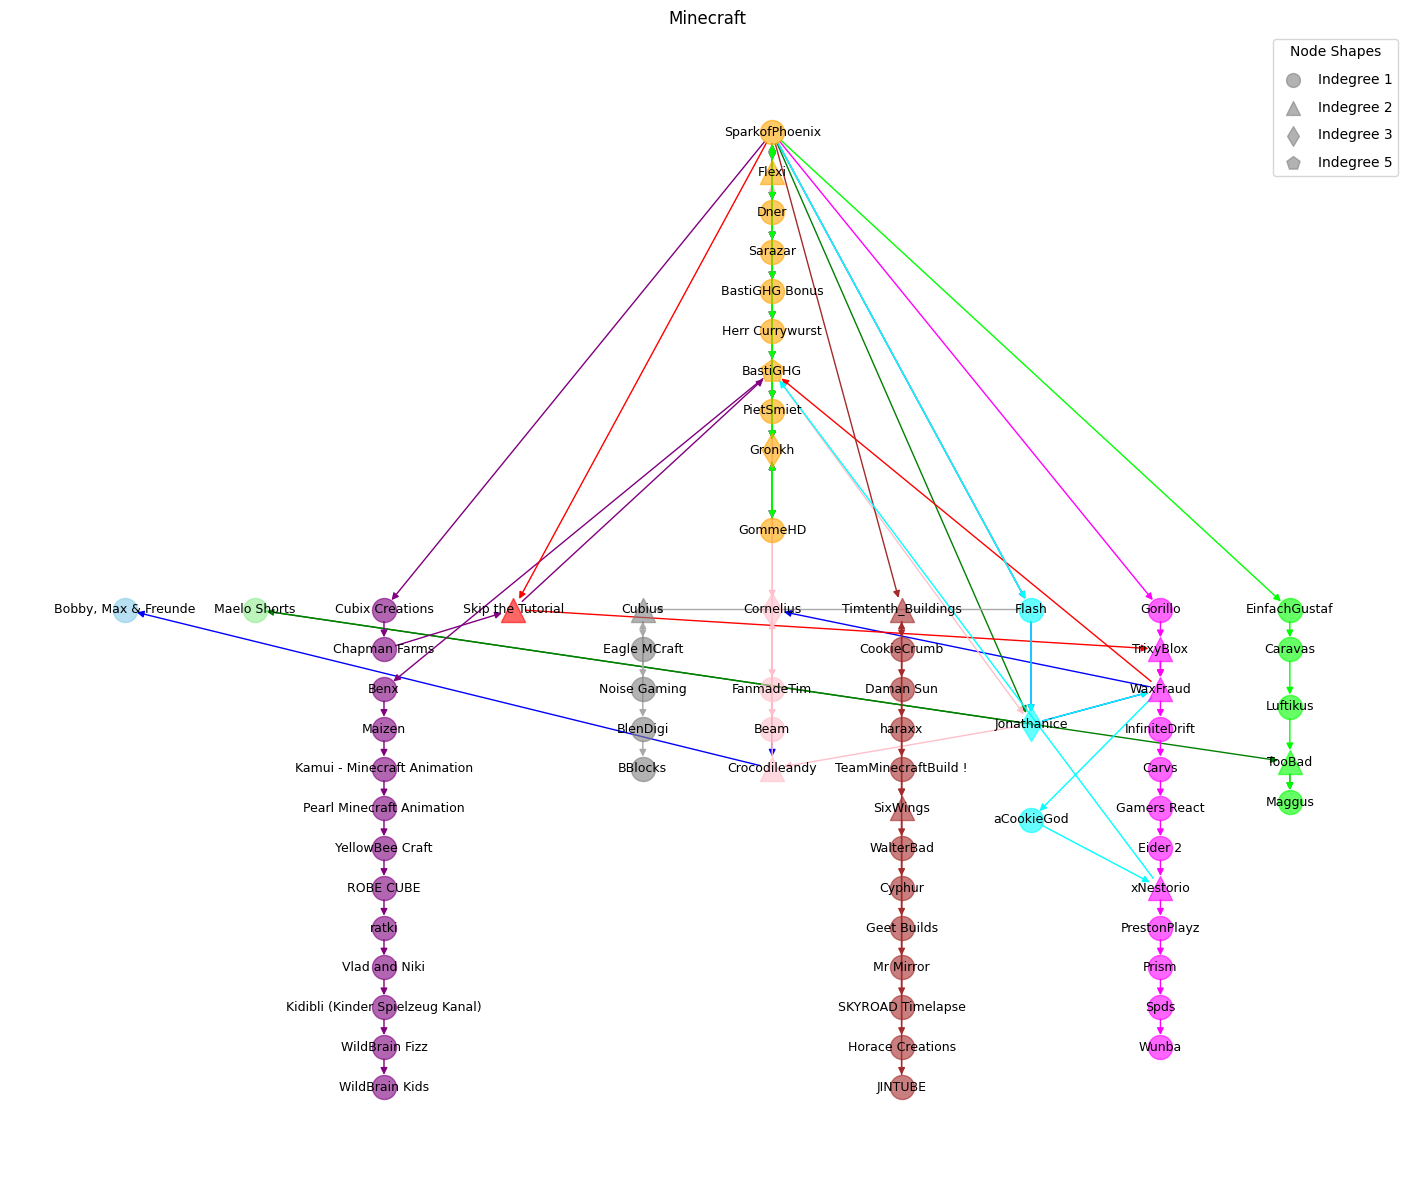

In [44]:
path = '../select_runs/Minecraft/'
name='Minecraft'
visualize_network_graph(path, name)

## TTT

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


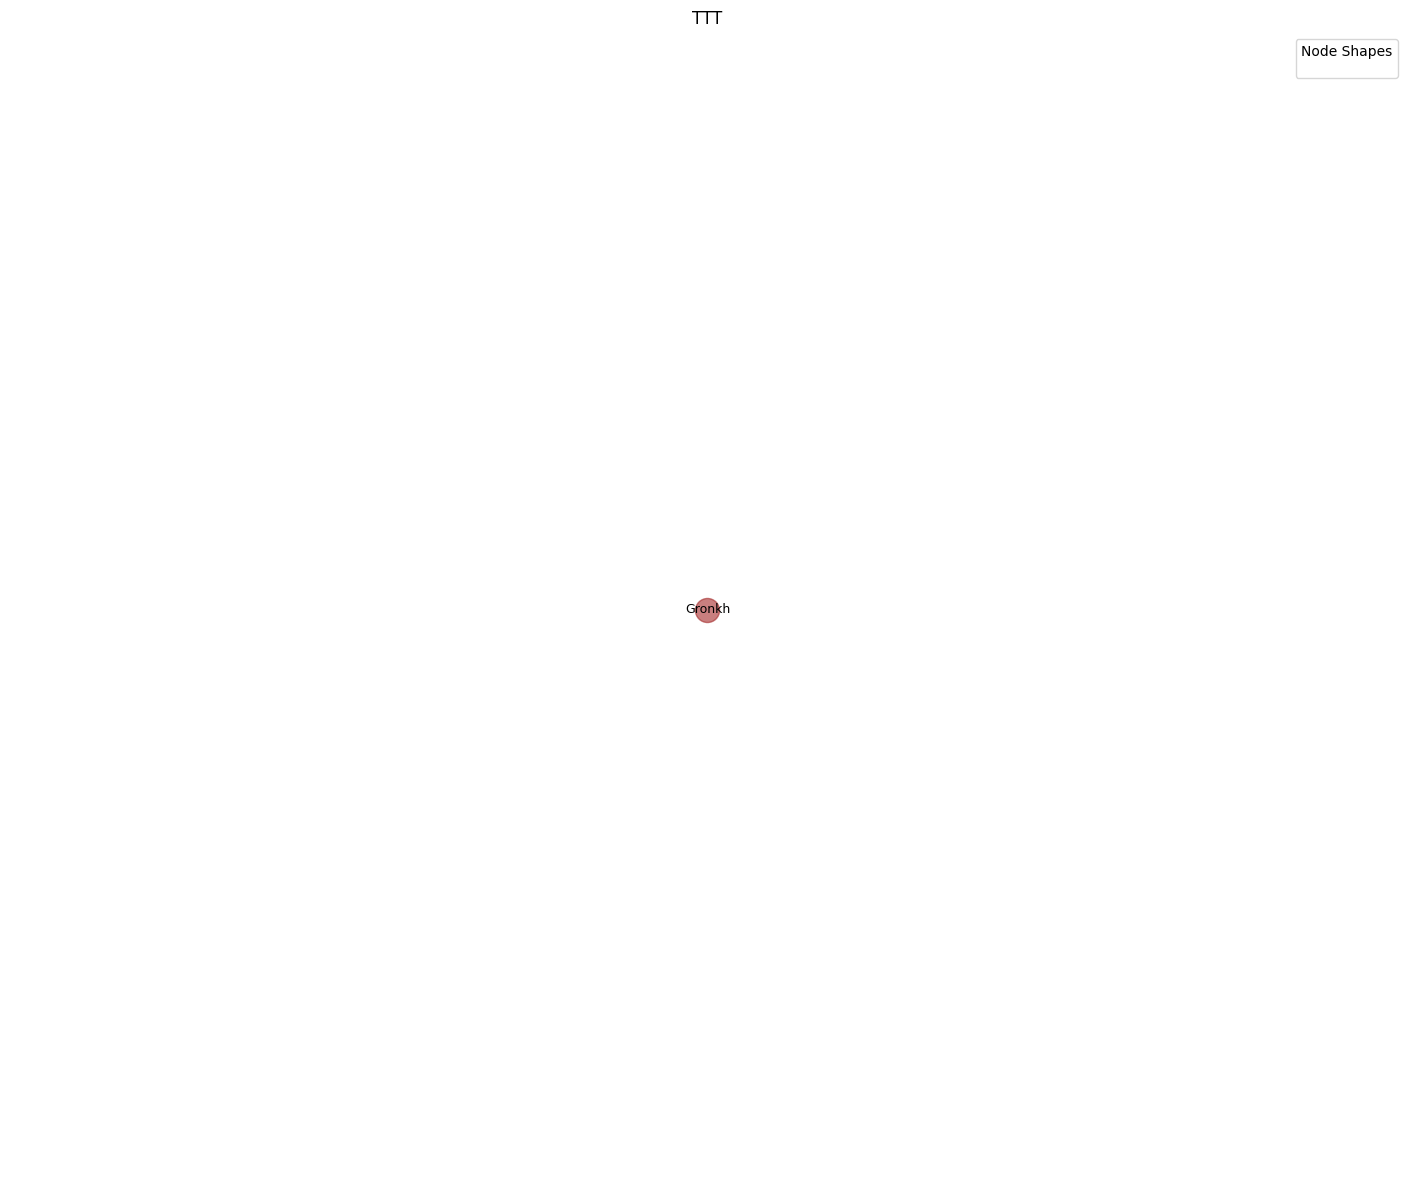

In [52]:
base_path = '../select_runs/TTT/'
name='TTT'
visualize_network_graph(base_path,  name)